<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a1/dl_assignment1_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Show the environment

In [1]:
!nvidia-smi

Sun Mar 28 16:56:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup logging

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

# Open and read the Fashion MNIST database
Code copied from sample provided

In [3]:

def get_fashion_mnist_data()->tuple:
  """
  Returns the training (X,Y) and evaluation (X,Y)
  The features have already been reshaped and converted to
  floats in the range [0,1]

  Also, the Y has been converted to categorical data.
  """
  # load the training and test data    
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)
  
  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0
  logging.debug( "Shape of training features " + str(tr_x.shape))
  logging.debug( "Shape of test features " + str(te_x.shape))
  
  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  tr_y = tr_y.T
  logging.debug("Shape of training labels " + str(tr_y.shape))
  
  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  te_y = te_y.T
  logging.debug("Shape of testing labels " + str(te_y.shape))

  tr_x = tf.convert_to_tensor(tr_x, dtype=tf.float32)
  tr_y = tf.convert_to_tensor(tr_y, dtype=tf.float32)
  te_x = tf.convert_to_tensor(te_x, dtype=tf.float32)
  te_y = tf.convert_to_tensor(te_y, dtype=tf.float32)

  return tr_x, tr_y, te_x, te_y

# Some utility functions
1. Forward Pass
2. Cross Entropy
3. Accuracy Score
4. Flatten Network
5. Optimize Network (Adam)

In [25]:
def make_layer(shape:list, layername:str)->tf.Variable:
  return tf.Variable(tf.random.normal(shape, mean=0, stddev=0.05, \
                                      dtype=tf.dtypes.float32),
                                      name=layername)

def softmax(a:tf.Tensor, axis:int=None)->tf.Tensor:
  t = tf.math.exp(a)
  s = tf.reduce_sum(t, axis=0)
  return tf.math.divide(t, s)
  #return tf.nn.softmax(a)

def cross_entropy(y_true, y_pred)->tf.Tensor:
  y_pred = tf.clip_by_value(y_pred, \
                            clip_value_min=1.0e-10, \
                            clip_value_max=tf.reduce_max(y_pred))
  y_pred = tf.math.multiply(y_true, tf.math.log(y_pred))
  y_pred = tf.multiply(y_pred, -1)
  # Find the average cross entropy, divide by number of samples
  divisor = y_pred.shape[1] if len(y_pred.shape) > 1 else 1
  y_pred = tf.math.divide(tf.reduce_sum(y_pred), divisor)
  return y_pred

def accuracy(y_true:tf.Tensor, y_pred:tf.Tensor)->float:
  logging.debug("y_true = " + str(y_true.shape) + \
                " y_pred = " + str(y_pred.shape))
  y_true = tf.transpose(y_true)
  logging.debug("y_true = " + str(y_true.shape) + \
                " y_pred = " + str(y_pred.shape))
  eq = tf.math.equal(y_true, y_pred)
  return float(eq[eq == True].shape[0]) / float(eq.shape[0])

def mean_absolute_error(y_true:tf.Tensor, y_pred:tf.Tensor)->tf.Variable:
  y_true = tf.transpose(y_true)
  logging.debug(y_true.shape, y_pred.shape)
  abs_dist = tf.math.abs(tf.math.subtract(y_true, y_pred))
  return tf.reduce_mean(abs_dist)

def mean_square_error(y_true:tf.Tensor, y_pred:tf.Tensor)->tf.Variable:
  return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

def mean_square_error_image(yt:tf.Tensor, yp:tf.Tensor)->tf.Variable:
  y1 = tf.math.multiply(yt, 255.0)
  y2 = tf.math.multiply(yp, 255.0)
  return mean_square_error(tf.transpose(y1), y2)

class NeuralNetwork(object):
  def __init__(self, network, dropout_probability=0.3):
    self.network = network
    self.prob_dropout = dropout_probability
    self.iterations = []
    self.train_accuracies = []
    self.test_accuracies = []
    self.train_losses = []
    self.test_losses = []

  def print_drop_matrix_stat(self, d:tf.Tensor)->None:
    ones = tf.ones(shape=d.shape)
    all = tf.reduce_sum(ones)
    this = tf.reduce_sum(d)
    print(tf.divide(this, all))

  def get_dropout_input(self, input:tf.Tensor)->tf.Tensor:
    prob_dropout = self.prob_dropout
    prob_threshold = 1 - prob_dropout
    drop_matrix = tf.random.uniform(shape=input.shape, minval=0,  maxval=1)
    drop_matrix = tf.math.less(drop_matrix, prob_threshold)
    drop_matrix = tf.cast(drop_matrix, dtype=tf.float32)
    input = tf.math.multiply(input, drop_matrix)
    input = tf.math.divide(input, prob_threshold)
    return input

  def forward_pass(self, tr_x, tr_y, layers):
    input = tf.transpose(tr_x)
    for weight, bias, activation, dropout in layers:
        if dropout:
          input = self.get_dropout_input(input)
        input = activation(tf.matmul(weight, input) + bias)
    return input
  
  def predict(self, tr_x, tr_y):
    input = tf.transpose(tr_x)
    for weight, bias, activation, dropout in self.network:
      input = activation(tf.matmul(weight, input) + bias)
    return input
  
  """
  Take a network which is a list of tuples, and flatten it
  to a list, so that we can call adam and gradient on it without 
  without any ugly code
  """
  def flatten_network(self, network:list)->list:
    out = []
    for weight, bias, act, dropout in network:
      out.append(weight)
      out.append(bias)
    return out
  
  """
  Use the adam optimizer to optimize a network based on the 
  gradients passed to it
  """
  def optimize_network(self, network:list, gradients:list)->None:
    adam_optimizer = tf.keras.optimizers.Adam()
    learnable_array = []
    adam_optimizer.apply_gradients(zip(gradients, \
                                       self.flatten_network(network)))
  
  def should_log(self, i:int, iterations:int):
    return (i == (iterations - 1)) or all([i == '0' for i in list(str(i)[1:])])
  
  """
  Train the network for a given number of iterations
  """
  def train_network(self, \
                    iterations:int, \
                    tr_x:tf.Tensor, tr_y:tf.Tensor, \
                    te_x:tf.Tensor, te_y:tf.Tensor, \
                    loss_fn, acc_fn, \
                    do_logging=True, \
                    use_argmax=True)->None:
    for i in range(iterations):
      with tf.GradientTape() as tape:
        y_pred = self.forward_pass(tr_x, tr_y, self.network)
        loss = loss_fn(tr_y, y_pred)
      gradients = tape.gradient(loss, self.flatten_network(self.network))

      if (use_argmax):
        tr_acc = acc = acc_fn(tf.argmax(tr_y), tf.argmax(y_pred)) \
                if None != acc_fn else float("NaN")
      else:
        tr_acc = acc = acc_fn(tr_y, y_pred) if None != acc_fn else float("NaN")
      tr_loss = loss

      #if 0 == i % 50 or i < 20 or i == (iterations - 1):
      if do_logging and self.should_log(i, iterations):
        printstr = f"Iteration {i:5d}  TRAIN LOSS - {loss:5.5f}  "
        printstr = printstr + f"TRAIN ACCURACY - {acc:5.5f}"

      y_pred = self.predict(te_x, te_y)
      te_loss = loss = loss_fn(te_y, y_pred)
      if (use_argmax):
        te_acc = acc = acc_fn(tf.argmax(te_y), tf.argmax(y_pred)) \
                if None != acc_fn else float("NaN")
      else:
        te_acc = acc = acc_fn(te_y, y_pred) if None != acc_fn else float("NaN")


      #if 0 == i % 50 or i < 20 or i == (iterations - 1):
      if do_logging and self.should_log(i, iterations):
        printstr = printstr + f"  TEST_LOSS = {loss:5.5f}  "
        printstr = printstr + f"TEST ACCURACY = {acc:5.5f}"
        logging.info(printstr)

      self.iterations.append(i)
      self.train_accuracies.append(tr_acc)
      self.train_losses.append(tr_loss)
      self.test_accuracies.append(te_acc)
      self.test_losses.append(te_loss)

      self.optimize_network(self.network, gradients)

    self.iterations = np.array(self.iterations)
    self.train_accuracies = np.array(self.train_accuracies)
    self.train_losses = np.array(self.train_losses)
    self.test_accuracies = np.array(self.test_accuracies)
    self.test_losses = np.array(self.test_losses)

# Question 1_1_1

## Create the network

In [5]:
def q_1_1_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
                              
  # Layer 1 has 200 neurons, and 784 features,
  # hence the array should be (200, 784)
  network = [
            # Layer 1, 200 nodes, ReLu
            (make_layer([200, 784], "L1 Weights"),
             make_layer([200, 1],   "L1 Bias"),
             tf.nn.relu,
             False),
            # Layer 2, 10 nodes, Softmax
            (make_layer([10, 200],  "L2 Weights"),
             make_layer([10, 1],    "L2 Bias"),
             softmax,
             False)
  ]

  nn = NeuralNetwork(network)
  nn.train_network(1000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)
  return nn

## Run the network and plot the graphs

2021-03-28 16:56:27,693 - root - INFO - Iteration   0  TRAIN LOSS - 2.36143  TRAIN ACCURACY - 0.08153  TEST_LOSS = 2.36078  TEST ACCURACY = 0.08240
2021-03-28 16:56:27,739 - root - INFO - Iteration   1  TRAIN LOSS - 2.14535  TRAIN ACCURACY - 0.28233  TEST_LOSS = 2.14590  TEST ACCURACY = 0.27920
2021-03-28 16:56:27,779 - root - INFO - Iteration   2  TRAIN LOSS - 1.96741  TRAIN ACCURACY - 0.44043  TEST_LOSS = 1.96869  TEST ACCURACY = 0.43520
2021-03-28 16:56:27,820 - root - INFO - Iteration   3  TRAIN LOSS - 1.80141  TRAIN ACCURACY - 0.55692  TEST_LOSS = 1.80354  TEST ACCURACY = 0.54980
2021-03-28 16:56:27,859 - root - INFO - Iteration   4  TRAIN LOSS - 1.64602  TRAIN ACCURACY - 0.60758  TEST_LOSS = 1.64844  TEST ACCURACY = 0.60370
2021-03-28 16:56:27,901 - root - INFO - Iteration   5  TRAIN LOSS - 1.50958  TRAIN ACCURACY - 0.62485  TEST_LOSS = 1.51336  TEST ACCURACY = 0.61300
2021-03-28 16:56:27,942 - root - INFO - Iteration   6  TRAIN LOSS - 1.40313  TRAIN ACCURACY - 0.60523  TEST_LOSS

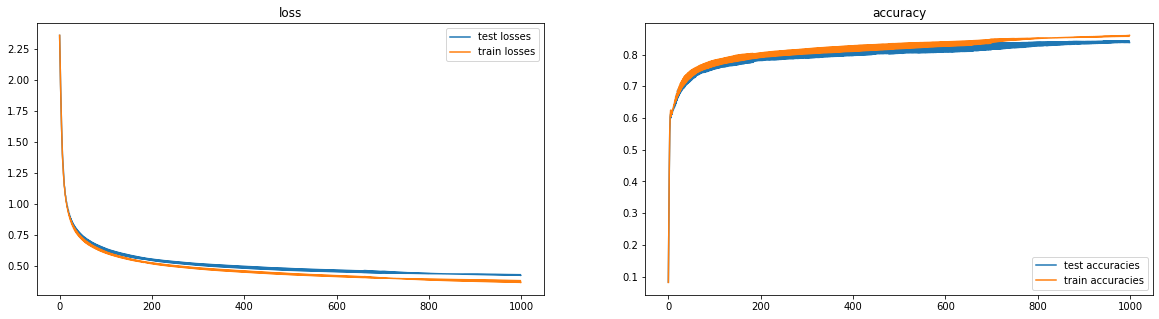

In [6]:
import matplotlib.pyplot as plt

nn = q_1_1_1()

plt.rcParams["figure.figsize"] = (20, 5)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(1, 2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
ax[0].set_title("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
ax[1].set_title("accuracy")
ax[1].legend()
plt.show()

# Question 1_2_1

## Create the network with dropout

In [7]:
def q_1_2_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  network = [
            # Layer 1, 300 Nodes, ReLu
            (make_layer([300, 784], "L2 Weghts", ),
             make_layer([300, 1],   "L1 Bias", ),
             tf.nn.relu,
             False),
            # Layer 2, 100 nodes, ReLu, dropout
            (make_layer([100, 300], "L2 Weights", ),
             make_layer([100, 1],   "L2 Bias", ),
             tf.nn.relu,
             True),
            # Layer 3, 10 nodes, Softmax
            (make_layer([10, 100],  "L3 Weghts", ),
             make_layer([10, 1],    "L3 Bias", ),
             softmax,
             False),]
  nn = NeuralNetwork(network, 0.5)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)

  return nn

## Run the network and plot the graph

2021-03-28 16:56:54,974 - root - INFO - Iteration   0  TRAIN LOSS - 2.29907  TRAIN ACCURACY - 0.10095  TEST_LOSS = 2.28888  TEST ACCURACY = 0.10160
2021-03-28 16:56:55,029 - root - INFO - Iteration   1  TRAIN LOSS - 2.20267  TRAIN ACCURACY - 0.21815  TEST_LOSS = 2.19213  TEST ACCURACY = 0.32510
2021-03-28 16:56:55,082 - root - INFO - Iteration   2  TRAIN LOSS - 2.10039  TRAIN ACCURACY - 0.31552  TEST_LOSS = 2.08363  TEST ACCURACY = 0.45800
2021-03-28 16:56:55,133 - root - INFO - Iteration   3  TRAIN LOSS - 1.98521  TRAIN ACCURACY - 0.40025  TEST_LOSS = 1.95790  TEST ACCURACY = 0.51240
2021-03-28 16:56:55,188 - root - INFO - Iteration   4  TRAIN LOSS - 1.85808  TRAIN ACCURACY - 0.46223  TEST_LOSS = 1.81483  TEST ACCURACY = 0.54440
2021-03-28 16:56:55,241 - root - INFO - Iteration   5  TRAIN LOSS - 1.71992  TRAIN ACCURACY - 0.50553  TEST_LOSS = 1.66167  TEST ACCURACY = 0.57970
2021-03-28 16:56:55,296 - root - INFO - Iteration   6  TRAIN LOSS - 1.58124  TRAIN ACCURACY - 0.54427  TEST_LOSS

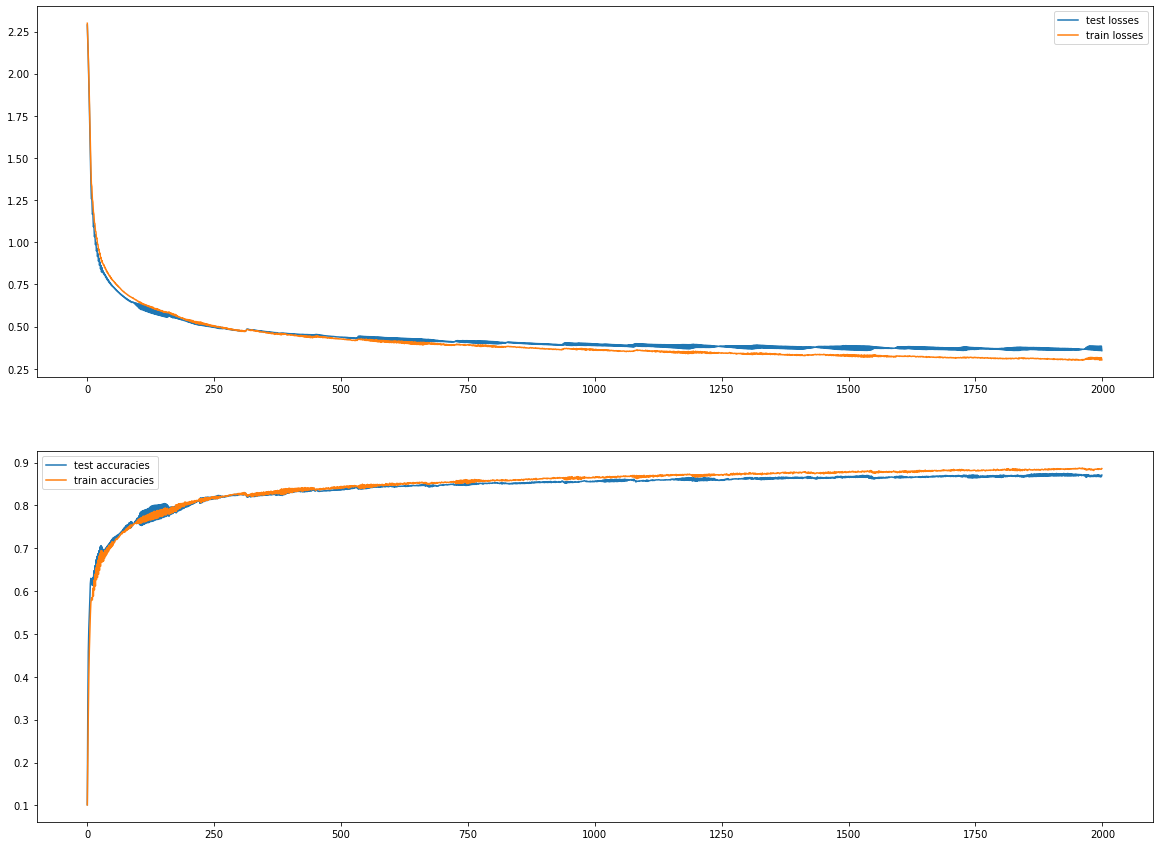

In [8]:
import matplotlib.pyplot as plt
import random

nn = q_1_2_1()

plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
#ax[0].suptitle("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
#ax[1].suptitle("accuracy")
ax[1].legend()
plt.show()

## Try the same thign without dropout and see the results

2021-03-28 16:58:32,984 - root - INFO - Iteration   0  TRAIN LOSS - 2.32703  TRAIN ACCURACY - 0.08087  TEST_LOSS = 2.32704  TEST ACCURACY = 0.07920
2021-03-28 16:58:33,028 - root - INFO - Iteration   1  TRAIN LOSS - 2.21977  TRAIN ACCURACY - 0.23320  TEST_LOSS = 2.22022  TEST ACCURACY = 0.23340
2021-03-28 16:58:33,072 - root - INFO - Iteration   2  TRAIN LOSS - 2.11127  TRAIN ACCURACY - 0.24537  TEST_LOSS = 2.11301  TEST ACCURACY = 0.24270
2021-03-28 16:58:33,115 - root - INFO - Iteration   3  TRAIN LOSS - 1.99562  TRAIN ACCURACY - 0.47838  TEST_LOSS = 1.99766  TEST ACCURACY = 0.47680
2021-03-28 16:58:33,159 - root - INFO - Iteration   4  TRAIN LOSS - 1.87388  TRAIN ACCURACY - 0.46015  TEST_LOSS = 1.87758  TEST ACCURACY = 0.45340
2021-03-28 16:58:33,202 - root - INFO - Iteration   5  TRAIN LOSS - 1.75319  TRAIN ACCURACY - 0.63393  TEST_LOSS = 1.75672  TEST ACCURACY = 0.62610
2021-03-28 16:58:33,245 - root - INFO - Iteration   6  TRAIN LOSS - 1.63771  TRAIN ACCURACY - 0.57852  TEST_LOSS

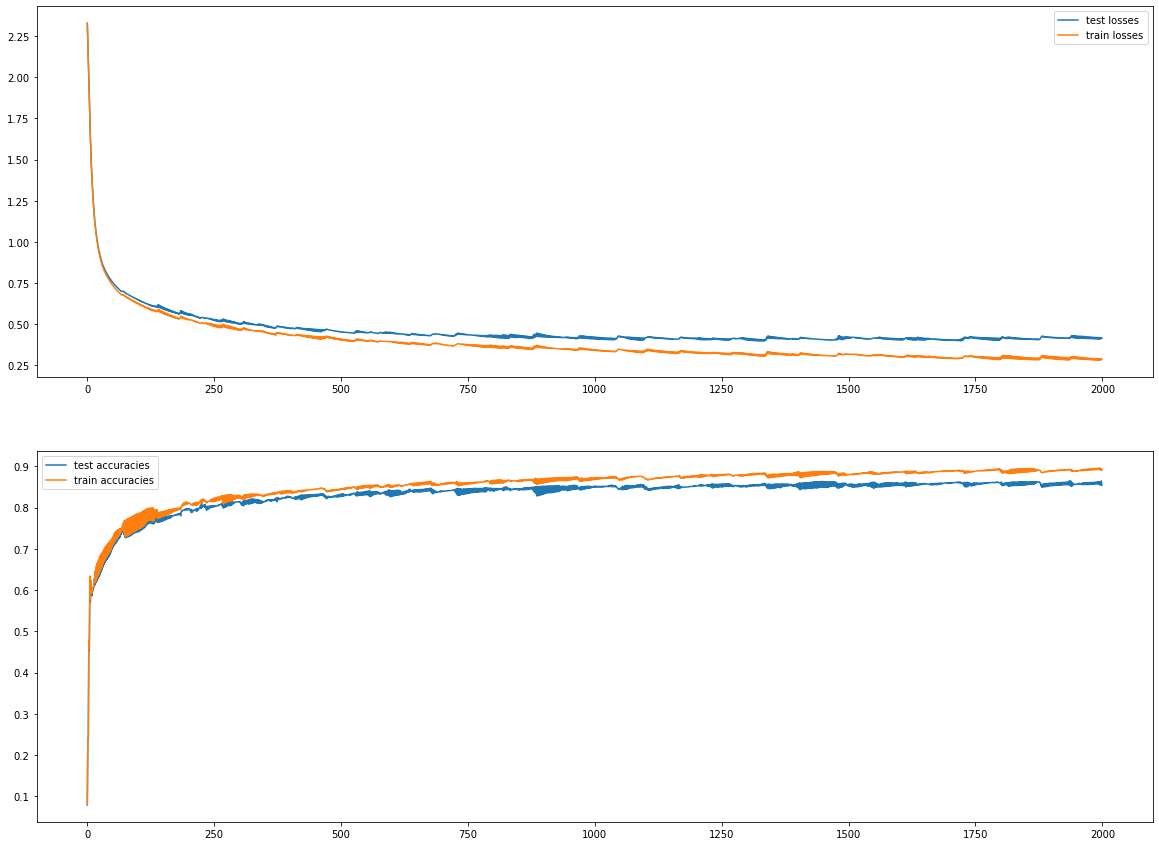

In [9]:
def q_1_2_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  network = [
            # Layer 1, 300 Nodes, ReLu
            (make_layer([300, 784], "L2 Weghts", ),
             make_layer([300, 1],   "L1 Bias", ),
             tf.nn.relu,
             False),
            # Layer 2, 100 nodes, ReLu, dropout
            (make_layer([100, 300], "L2 Weights", ),
             make_layer([100, 1],   "L2 Bias", ),
             tf.nn.relu,
             False),
            # Layer 3, 10 nodes, Softmax
            (make_layer([10, 100],  "L3 Weghts", ),
             make_layer([10, 1],    "L3 Bias", ),
             softmax,
             False),]
  nn = NeuralNetwork(network)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)

  return nn


import matplotlib.pyplot as plt
import random

nn = q_1_2_1()

plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
#ax[0].suptitle("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
#ax[1].suptitle("accuracy")
ax[1].legend()
plt.show()

## See how things change as the dropout rate is changed

2021-03-28 18:56:26,110 - root - INFO - Training with dropout rate = 0
2021-03-28 18:56:26,218 - root - INFO - Iteration     0  TRAIN LOSS - 2.33339  TRAIN ACCURACY - 0.08473  TEST_LOSS = 2.33447  TEST ACCURACY = 0.08130
2021-03-28 18:56:26,284 - root - INFO - Iteration     1  TRAIN LOSS - 2.19471  TRAIN ACCURACY - 0.35720  TEST_LOSS = 2.19668  TEST ACCURACY = 0.35630
2021-03-28 18:56:26,348 - root - INFO - Iteration     2  TRAIN LOSS - 2.06286  TRAIN ACCURACY - 0.47327  TEST_LOSS = 2.06614  TEST ACCURACY = 0.46470
2021-03-28 18:56:26,407 - root - INFO - Iteration     3  TRAIN LOSS - 1.92692  TRAIN ACCURACY - 0.55252  TEST_LOSS = 1.93146  TEST ACCURACY = 0.53600
2021-03-28 18:56:26,460 - root - INFO - Iteration     4  TRAIN LOSS - 1.78541  TRAIN ACCURACY - 0.58542  TEST_LOSS = 1.79099  TEST ACCURACY = 0.57490
2021-03-28 18:56:26,513 - root - INFO - Iteration     5  TRAIN LOSS - 1.63827  TRAIN ACCURACY - 0.61882  TEST_LOSS = 1.64499  TEST ACCURACY = 0.60120
2021-03-28 18:56:26,565 - roo

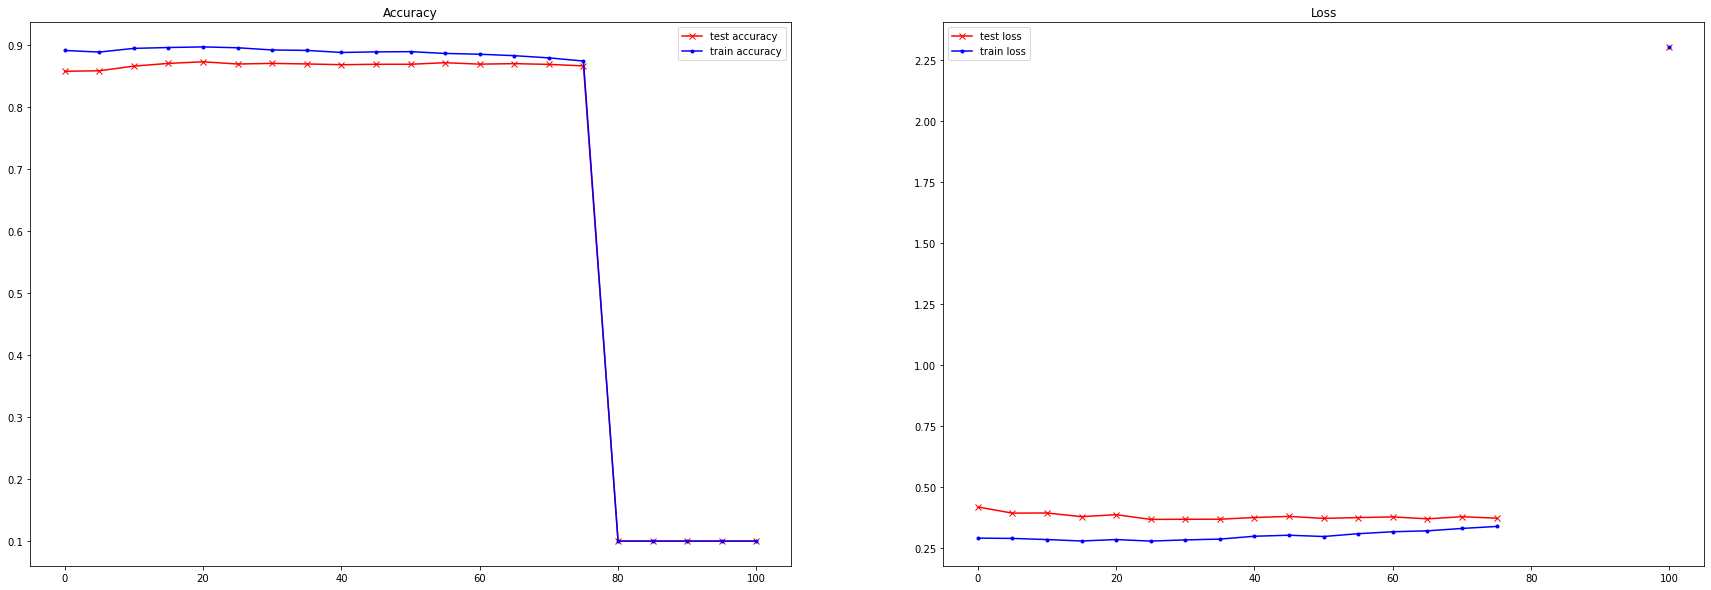

In [29]:
def norm(x):
  return -1 if x == None or x < 0 or x == float("NaN") else x

record = []
for i in range(0, 101, 5):
  tf.random.set_seed(0)
  np.random.seed(0)
  random.seed(0)
  network = [
            # Layer 1, 300 Nodes, ReLu
            (make_layer([300, 784], "L2 Weghts", ),
              make_layer([300, 1],   "L1 Bias", ),
              tf.nn.relu,
              False),
            # Layer 2, 100 nodes, ReLu, dropout
            (make_layer([100, 300], "L2 Weights", ),
              make_layer([100, 1],   "L2 Bias", ),
              tf.nn.relu,
              True),
            # Layer 3, 10 nodes, Softmax
            (make_layer([10, 100],  "L3 Weghts", ),
              make_layer([10, 1],    "L3 Bias", ),
              softmax,
              False),]

  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  dropout_prob = i / 100.0
  logging.info(f"Training with dropout rate = {i}")
  nn = NeuralNetwork(network, dropout_probability=dropout_prob)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, \
                   cross_entropy, accuracy, do_logging=True)
  test_accuracy = norm(nn.test_accuracies[-1])
  test_loss = norm(nn.test_losses[-1])
  train_accuracy = norm(nn.train_accuracies[-1])
  train_loss = norm(nn.train_losses[-1])
  record.append((i, test_accuracy, test_loss, train_accuracy, train_loss, ))
  logging.info(f"Dropout: {i:3d}  Train Accuracy: {train_accuracy:5.5f}     " +
               f"Test Accuracy: {test_accuracy:5.5f}     " +
               f"Train Loss: {train_loss:5.5f}     " +
               f"Test Loss: {test_loss:5.5f}")



def myplot(ax, record:list, index:int, colr:str, labstr:str):
  x_axis = [item[0] for item in record]
  y_axis = [item[index] for item in record]
  markr = 'x' if colr == 'red' else '.'
  ax.plot(x_axis, y_axis, label=labstr, marker=markr, color=colr)


plt.rcParams["figure.figsize"] = (30, 10)
fig, ax = plt.subplots(1, 2)
myplot(ax[0], record, 1, 'red', 'test accuracy')
myplot(ax[1], record, 2, 'red', 'test loss')
myplot(ax[0], record, 3, 'blue', 'train accuracy')
myplot(ax[1], record, 4, 'blue', 'train loss')
ax[0].set_title('Accuracy')
ax[1].set_title('Loss')
ax[0].legend()
ax[1].legend()
plt.show()

# Question 1_3_1
The first part of the question is to read the data set and inject noise into it
The second part is the autoencoder

## Create Network, inject noise, train

2021-03-28 20:15:31,619 - root - INFO - Iteration     0  TRAIN LOSS - 0.38266  TRAIN ACCURACY - 11081.65527  TEST_LOSS = 0.38129  TEST ACCURACY = 11032.45508
2021-03-28 20:15:31,709 - root - INFO - Iteration     1  TRAIN LOSS - 0.38231  TRAIN ACCURACY - 11059.11133  TEST_LOSS = 0.38094  TEST ACCURACY = 11009.98828
2021-03-28 20:15:31,785 - root - INFO - Iteration     2  TRAIN LOSS - 0.38194  TRAIN ACCURACY - 11036.14551  TEST_LOSS = 0.38058  TEST ACCURACY = 10987.10156
2021-03-28 20:15:31,866 - root - INFO - Iteration     3  TRAIN LOSS - 0.38157  TRAIN ACCURACY - 11012.35059  TEST_LOSS = 0.38020  TEST ACCURACY = 10963.38867
2021-03-28 20:15:31,941 - root - INFO - Iteration     4  TRAIN LOSS - 0.38117  TRAIN ACCURACY - 10987.28516  TEST_LOSS = 0.37981  TEST ACCURACY = 10938.40625
2021-03-28 20:15:32,016 - root - INFO - Iteration     5  TRAIN LOSS - 0.38075  TRAIN ACCURACY - 10960.39941  TEST_LOSS = 0.37939  TEST ACCURACY = 10911.61133
2021-03-28 20:15:32,090 - root - INFO - Iteration   

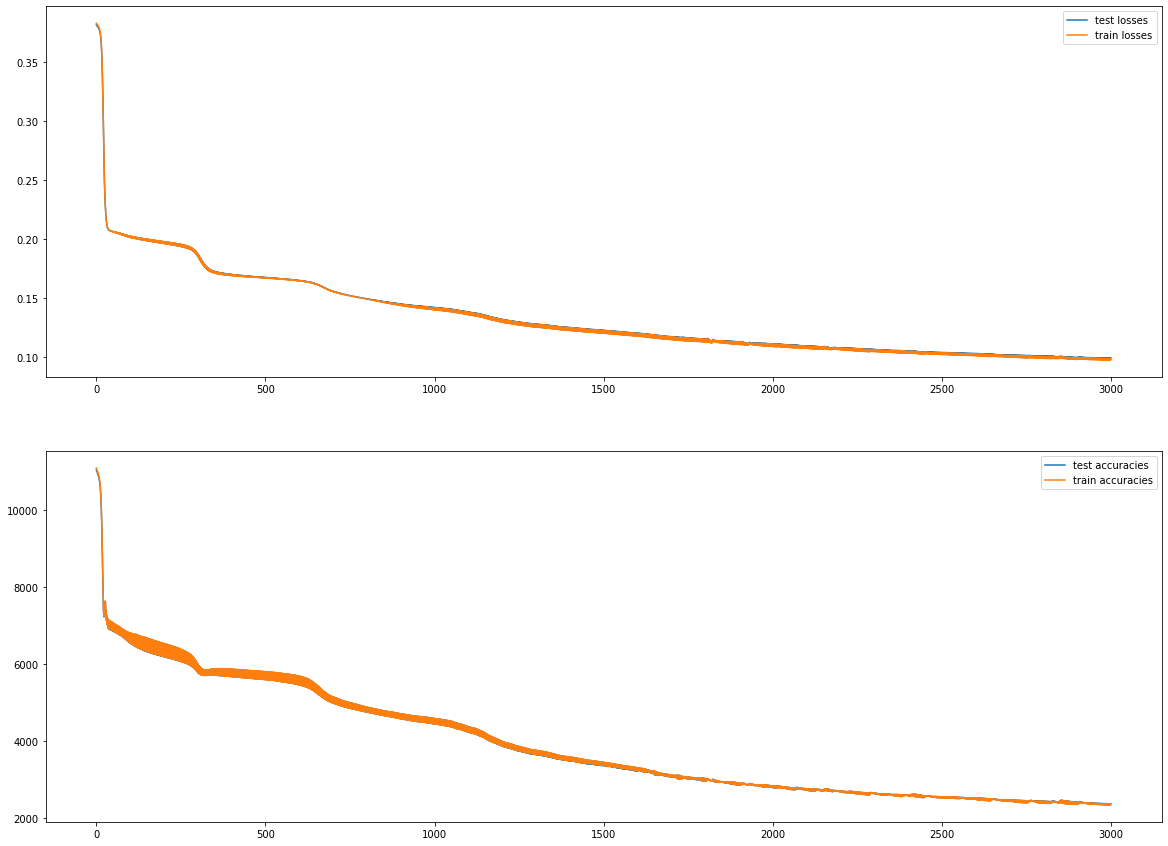

In [30]:
def get_noisy_images(x:tf.Tensor, \
                     noise_factor:float=0.2, \
                     clip_min_value:float=0.0, \
                     clip_max_value:float=1.0) ->tf.Tensor:
  x_noisy = x + noise_factor * tf.random.normal(shape=x.shape)
  x_noisy = tf.clip_by_value(x_noisy, \
                             clip_value_min=clip_min_value, \
                             clip_value_max=clip_max_value)
  return x_noisy

def q_1_3_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  tr_x_noisy = get_noisy_images(tr_x)
  te_x_noisy = get_noisy_images(te_x)

  network = [
            # Layer 1, 128 Nodes
            (make_layer([128, 784], "L1 weights"),
             make_layer([128, 1],   "L1 bias"),
             tf.nn.relu,
             False,),
            # Layer 2, 64 nodes
            (make_layer([64, 128],  "L2 weights"),
             make_layer([64, 1],    "L2 bias"),
             tf.nn.relu,
             False,),
            # Layer 3, 32 nodes
            (make_layer([32, 64],   "L3 weights"),
             make_layer([32, 1],    "L3 bias"),
             tf.nn.relu,
             False,),
            # Layer 4, 64 nodes
            (make_layer([64, 32],   "L4 weights"),
             make_layer([64, 1],    "L4 bias"),
             tf.nn.relu,
             False,),
            # Layer 5, 128 nodes
            (make_layer([128, 64],  "L5 weights"),
             make_layer([128, 1],   "L5 bias"),
             tf.nn.relu,
             False,),
            # Layer 6, 784 nodes
            (make_layer([784, 128], "L6 weights"),
             make_layer([784, 1],   "L6 bias"),
             tf.nn.sigmoid,
             False,),
  ]

  nn = NeuralNetwork(network)
  nn.train_network(3000, \
                   tr_x_noisy, tr_x, \
                   te_x_noisy, te_x, \
                   mean_absolute_error, mean_square_error_image, \
                   use_argmax=False)

  return nn


import matplotlib.pyplot as plt

nn = q_1_3_1()
tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
te_x_noisy = get_noisy_images(te_x)
denoised = nn.predict(te_x_noisy, None)
print(denoised.shape)


plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
#ax[0].suptitle("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
#ax[1].suptitle("accuracy")
ax[1].legend()
plt.show()

## Classify and plot display side by side

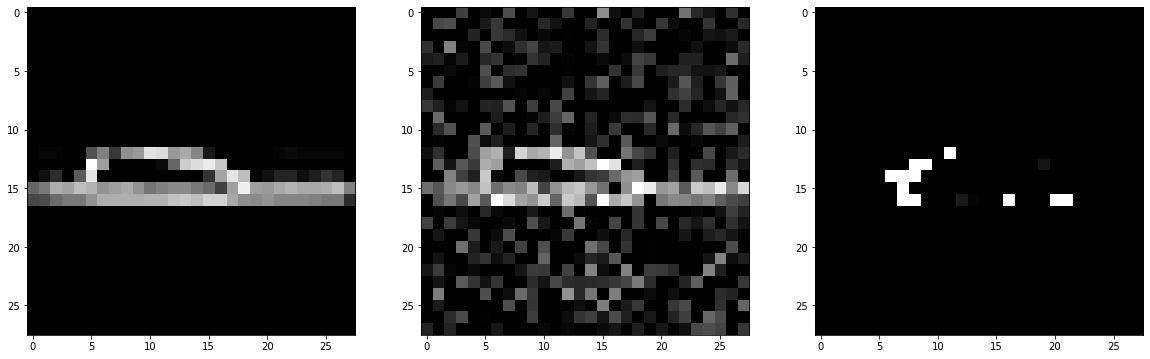

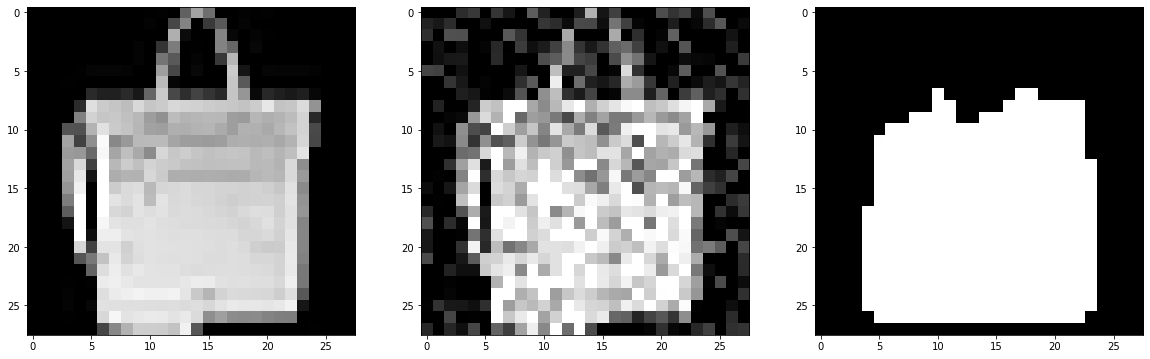

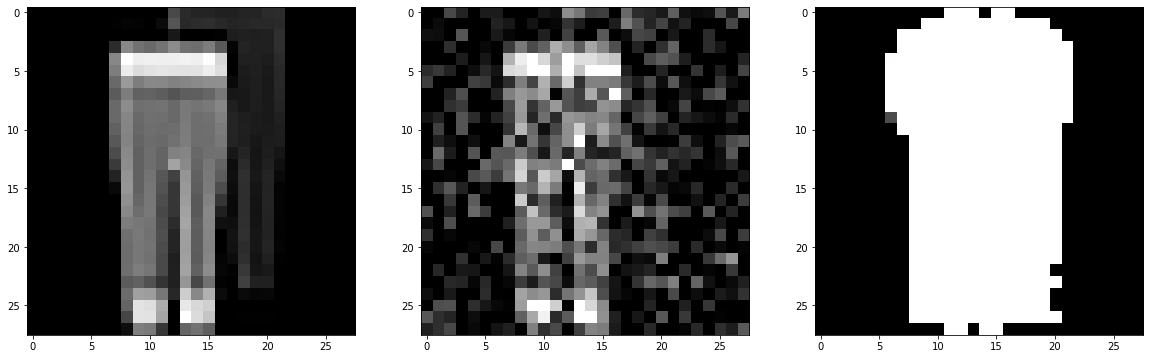

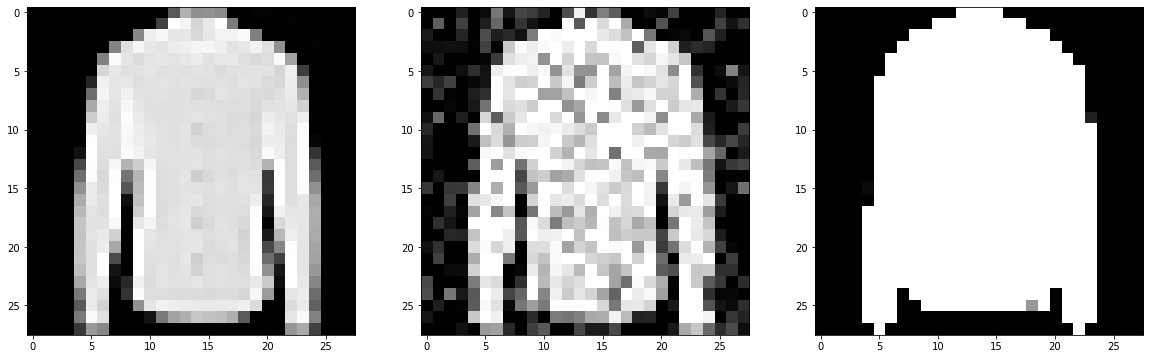

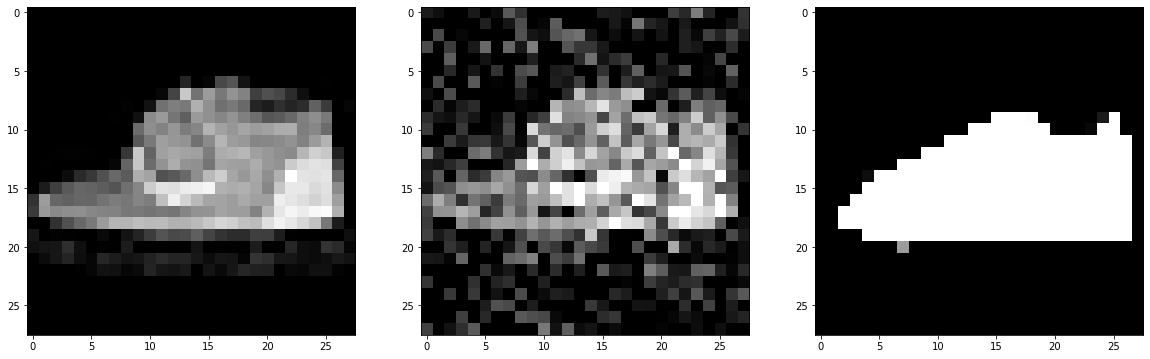

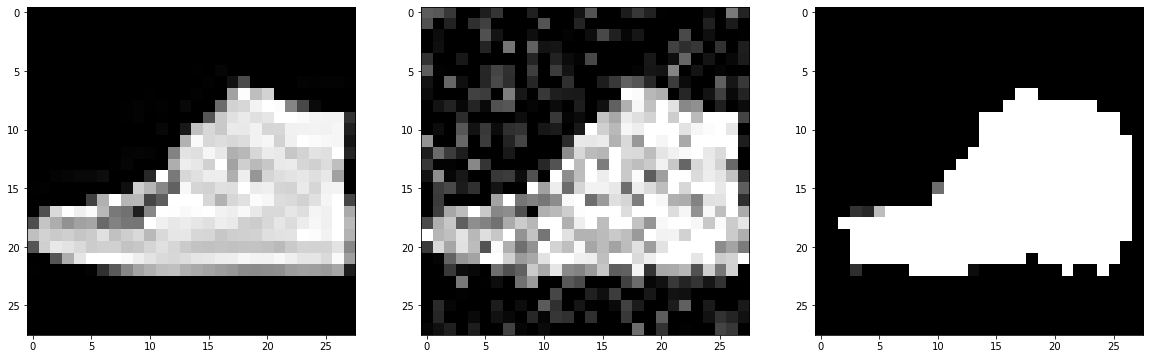

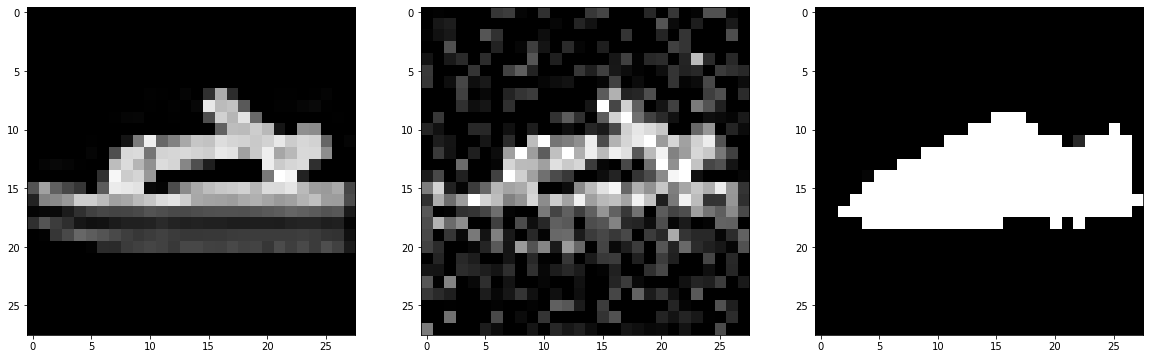

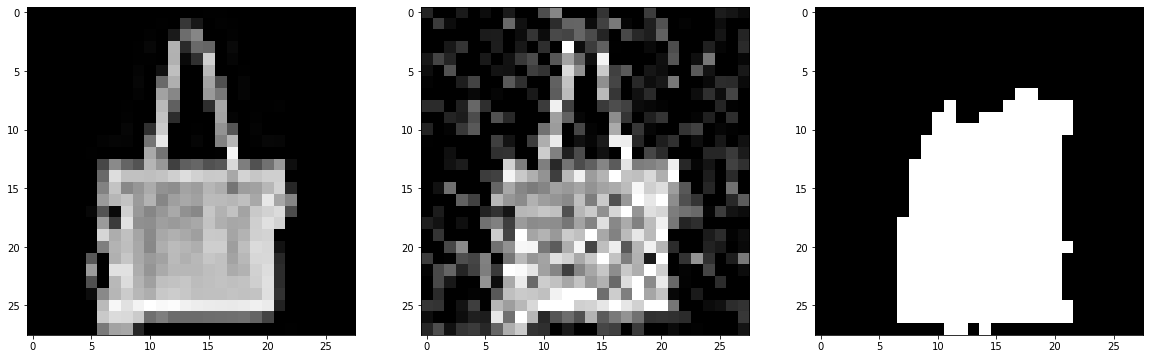

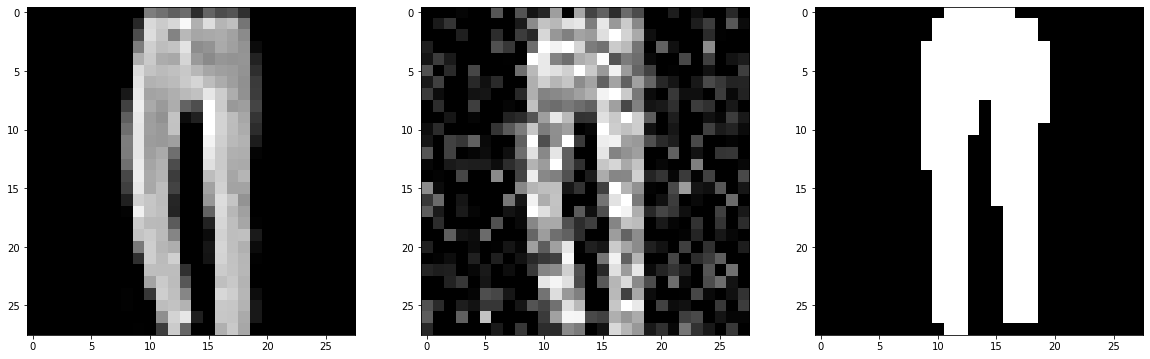

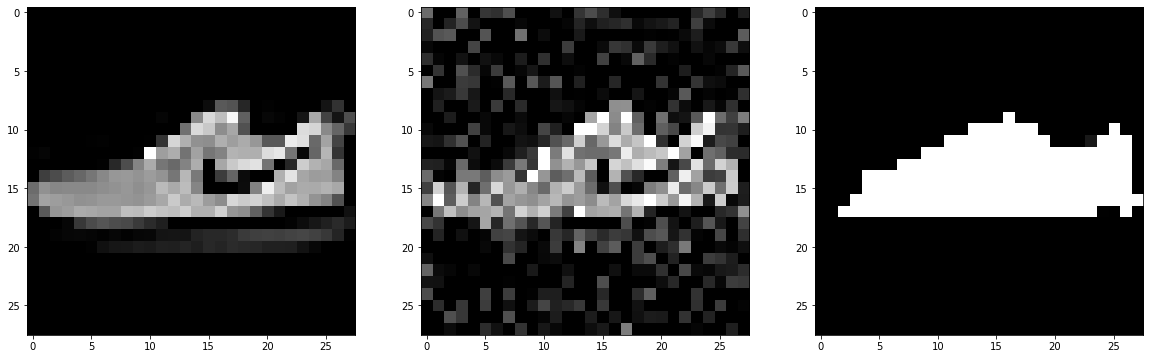

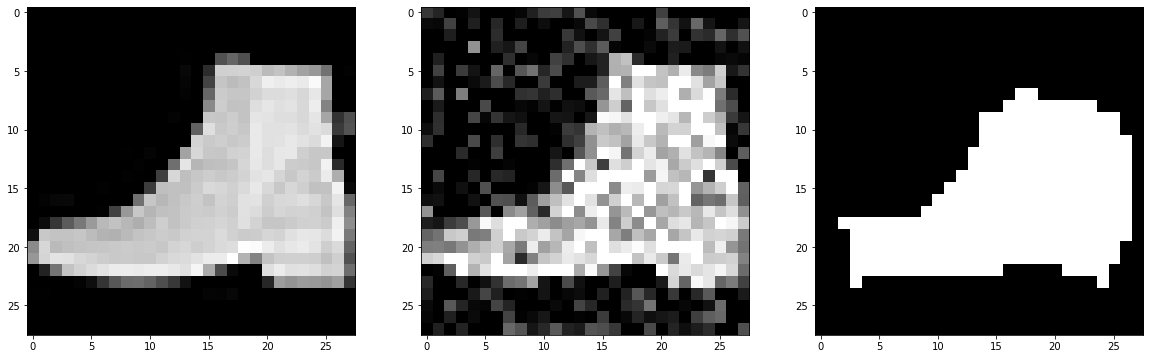

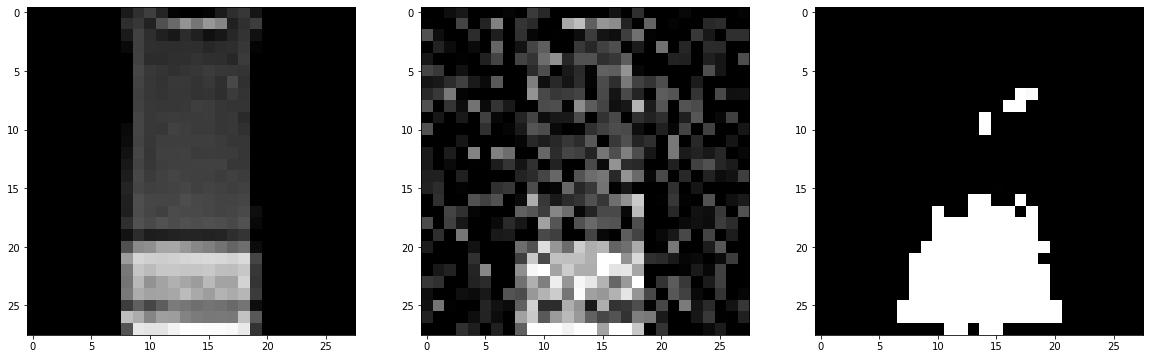

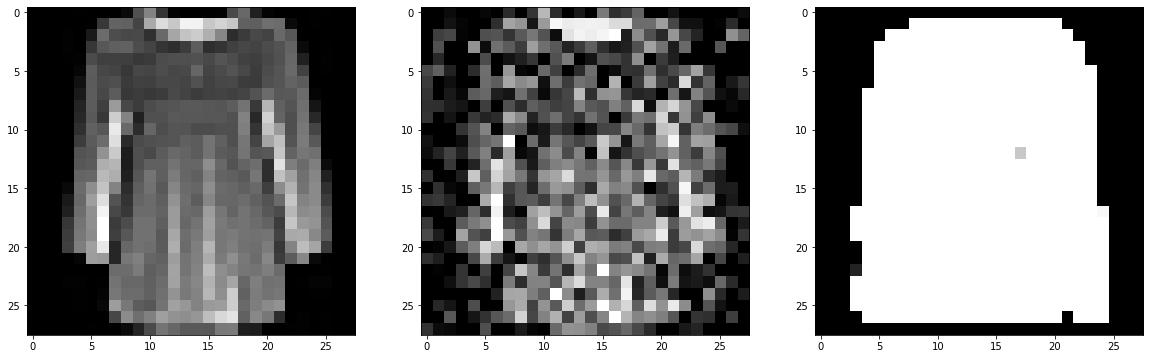

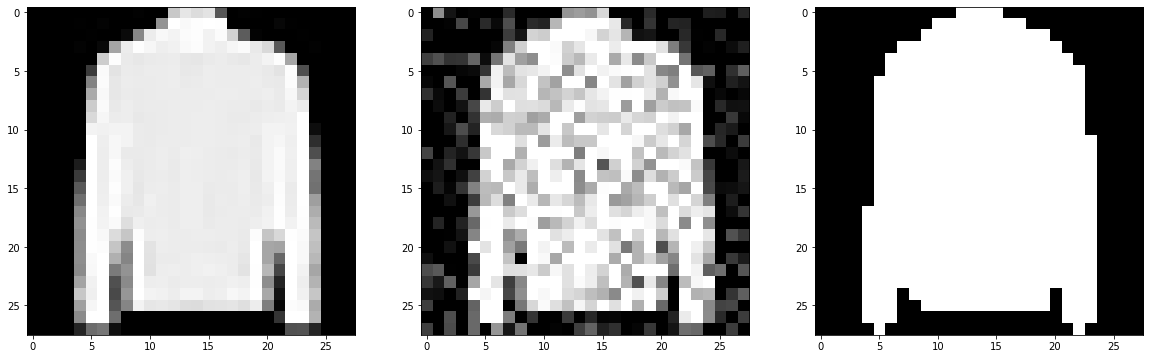

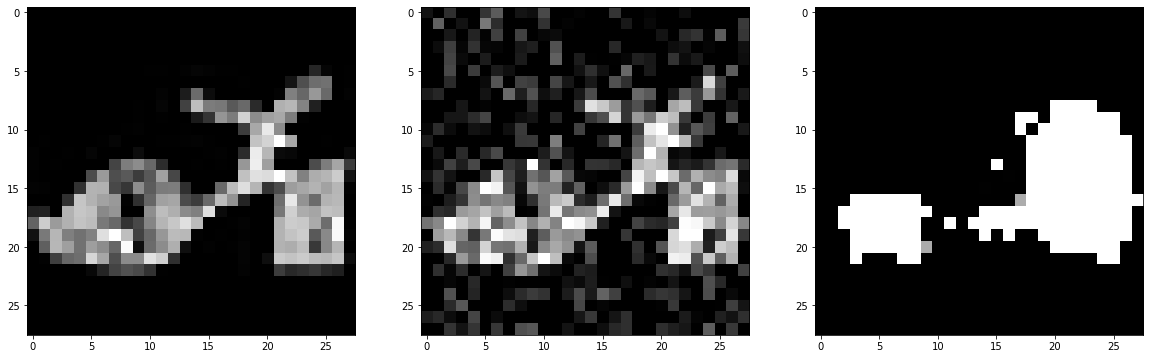

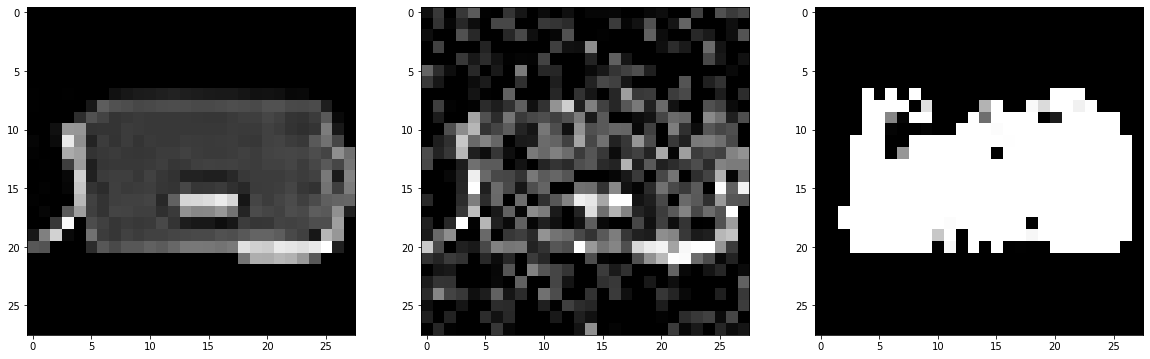

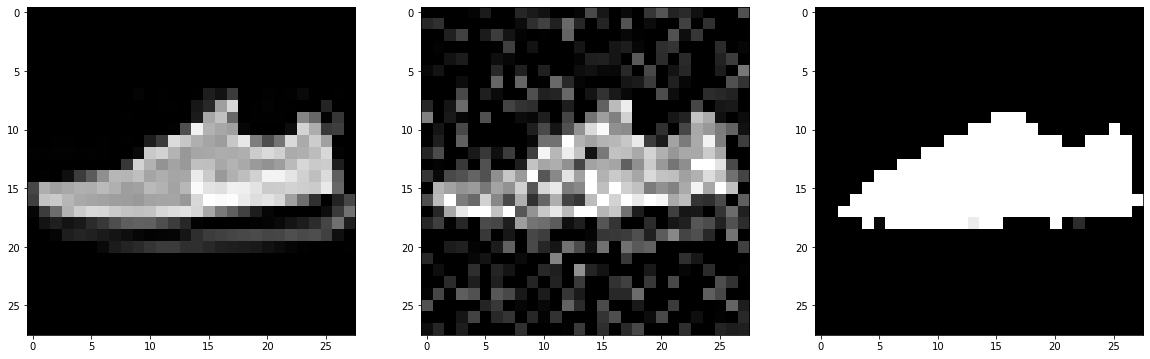

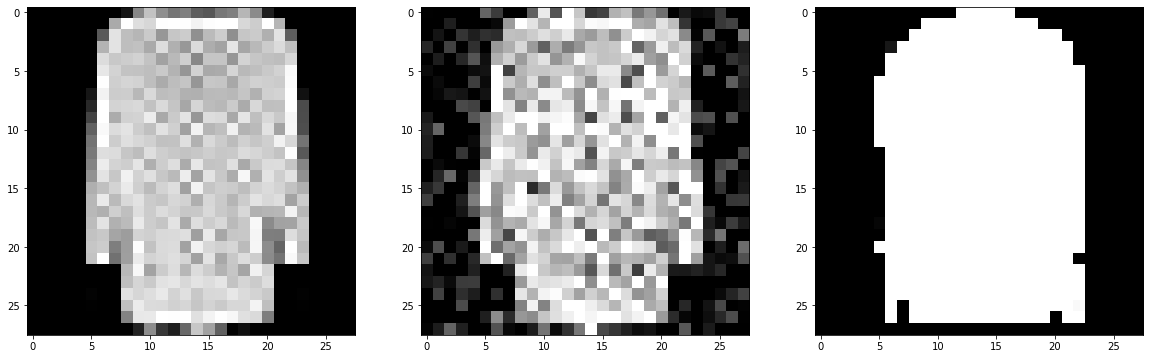

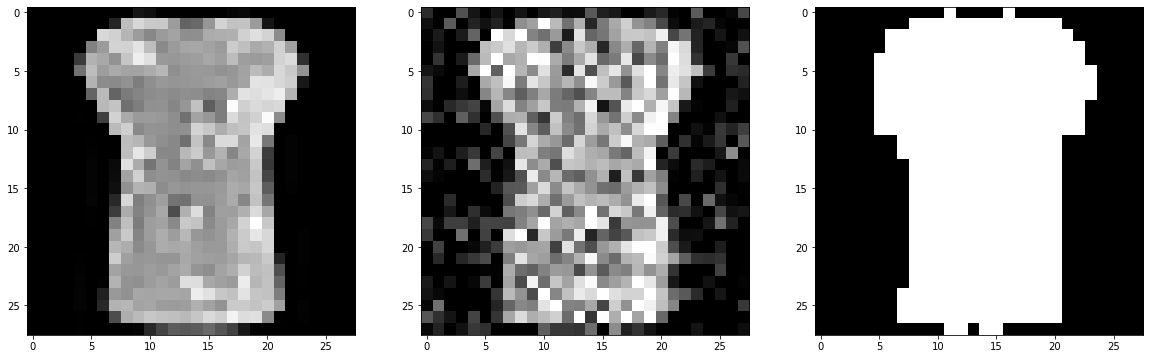

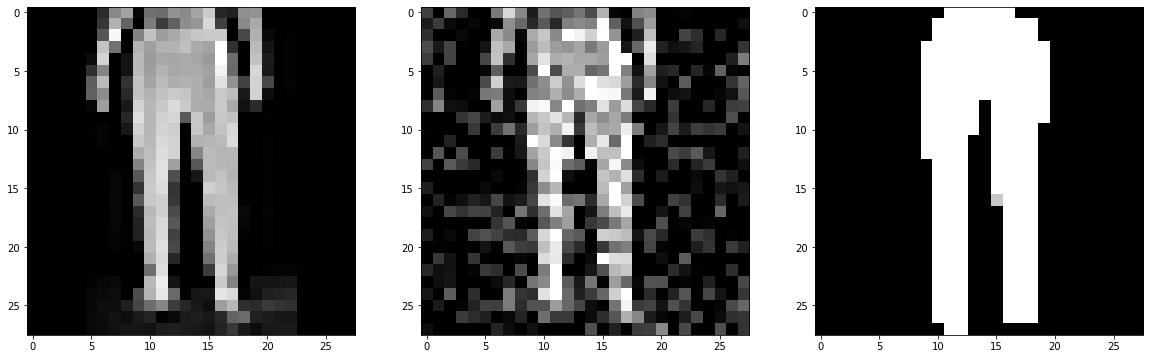

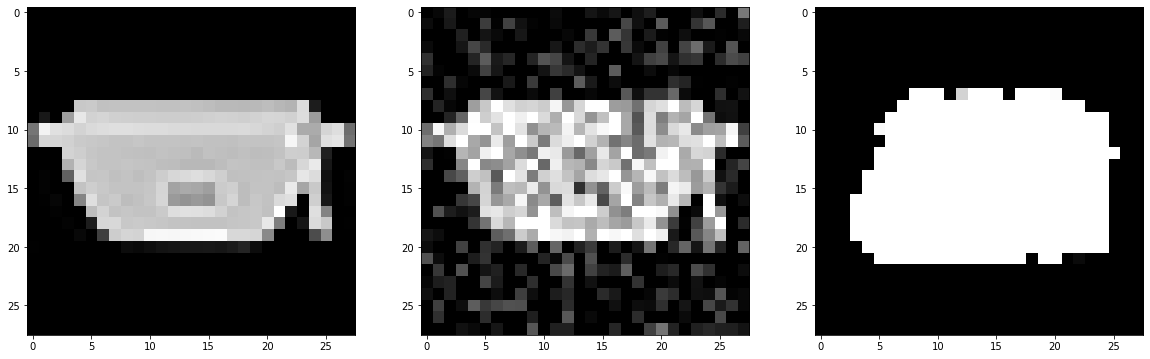

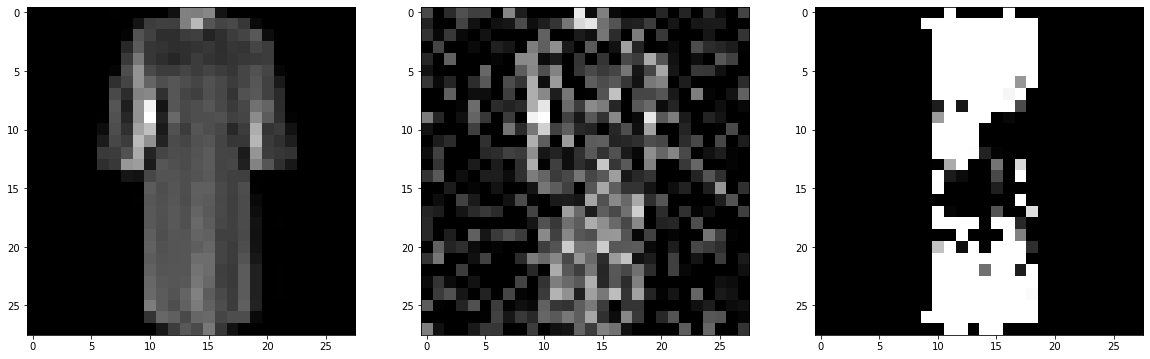

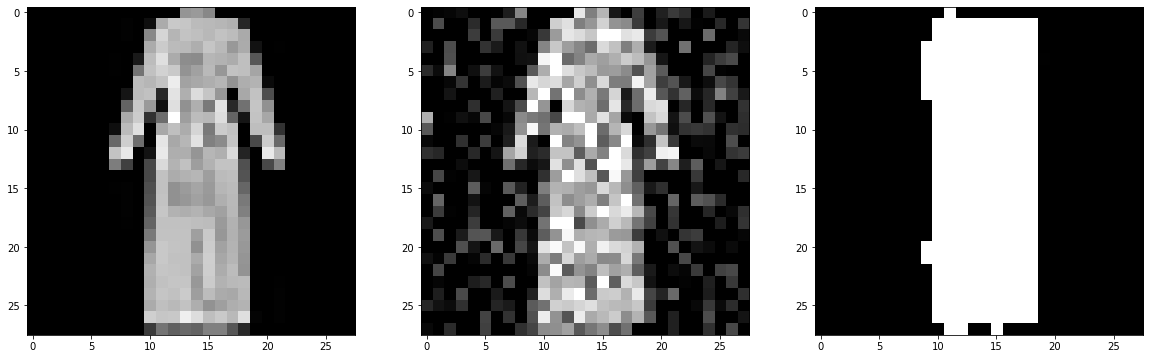

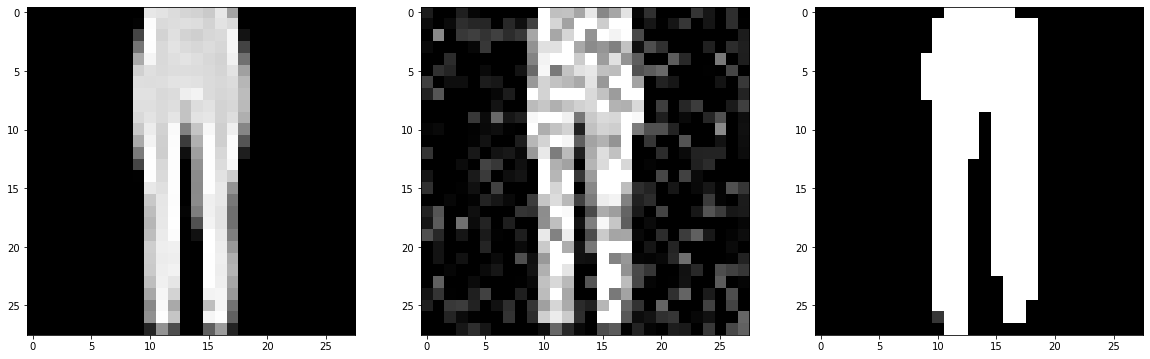

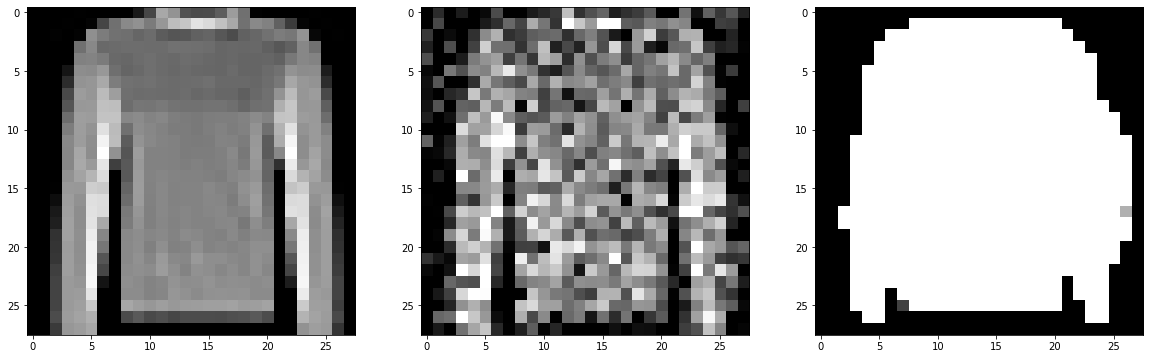

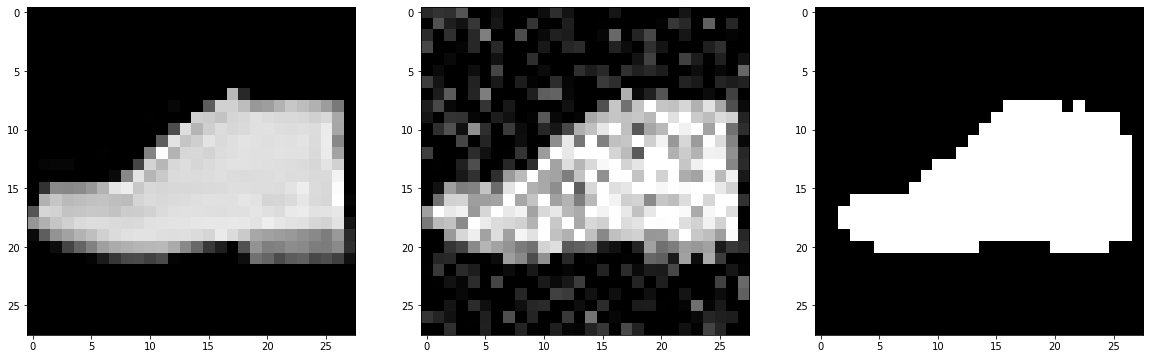

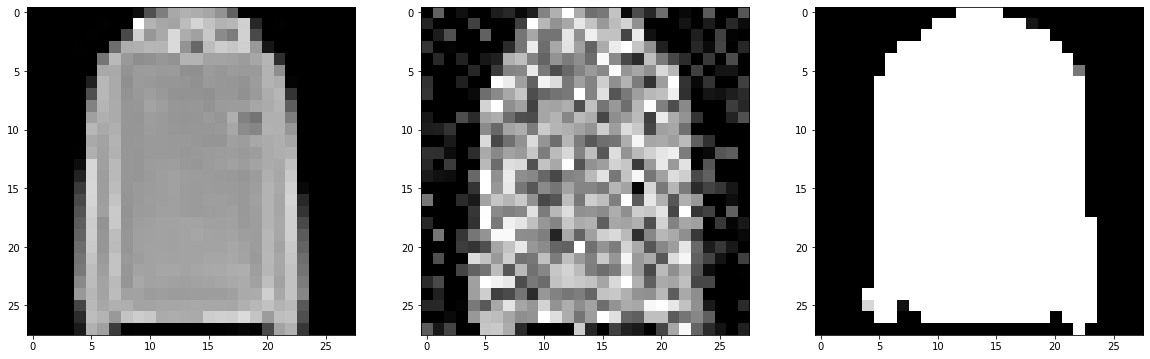

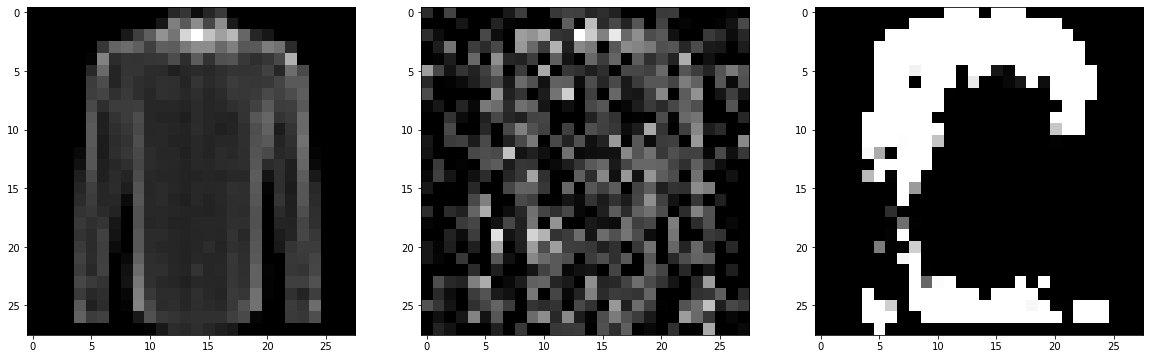

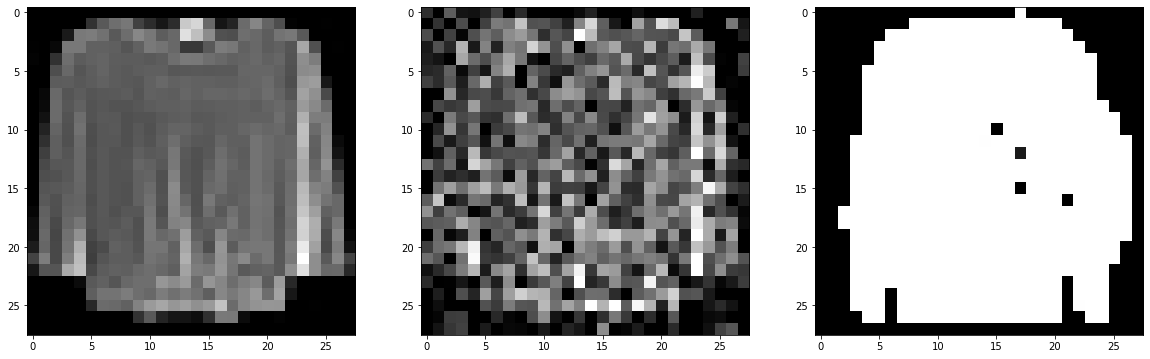

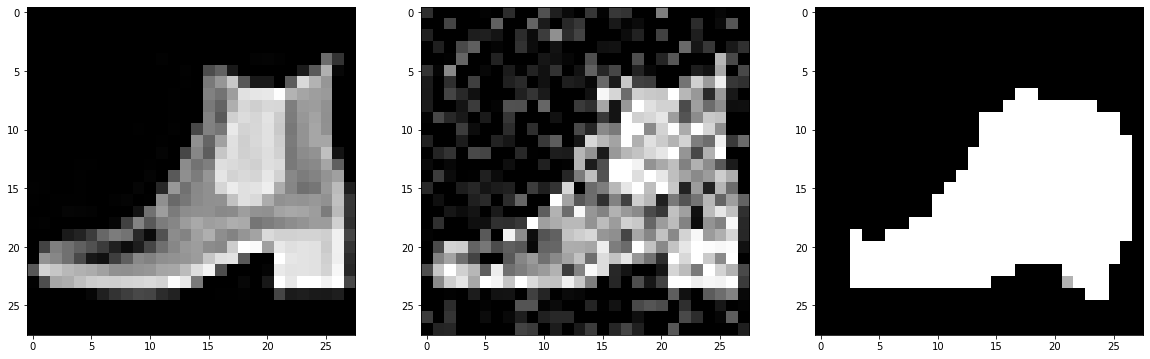

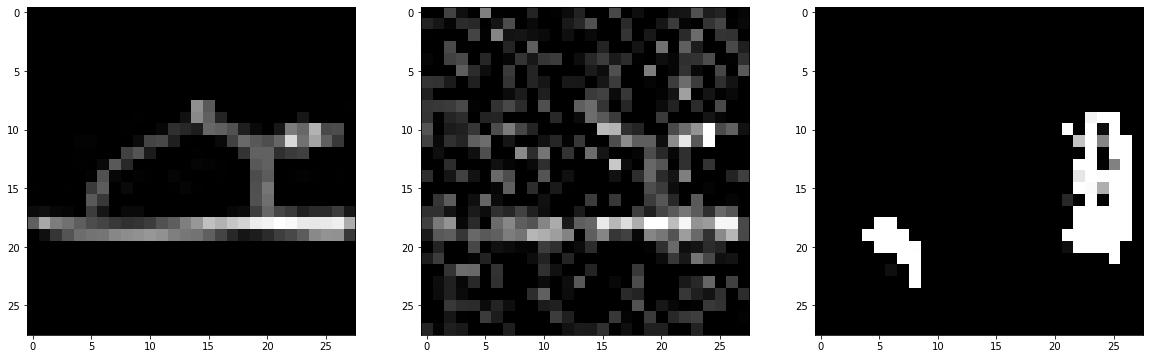

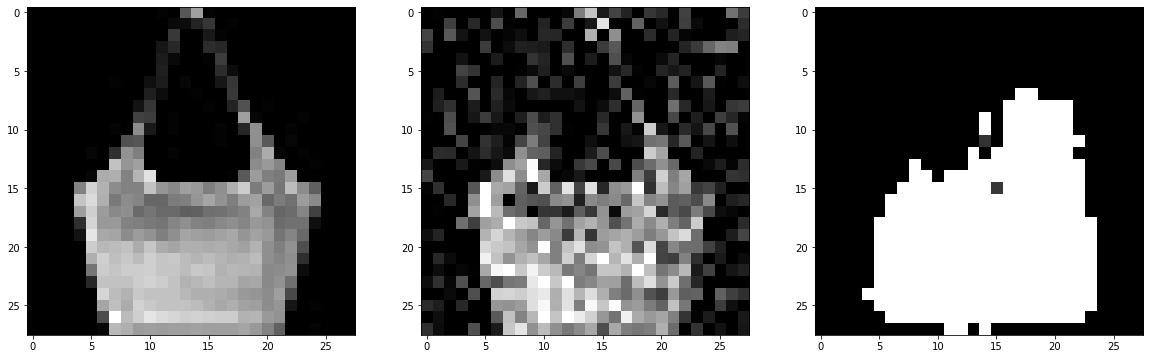

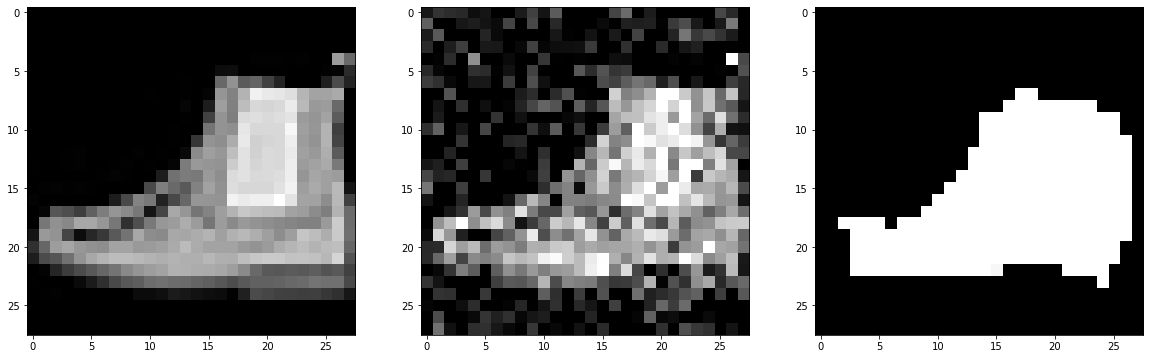

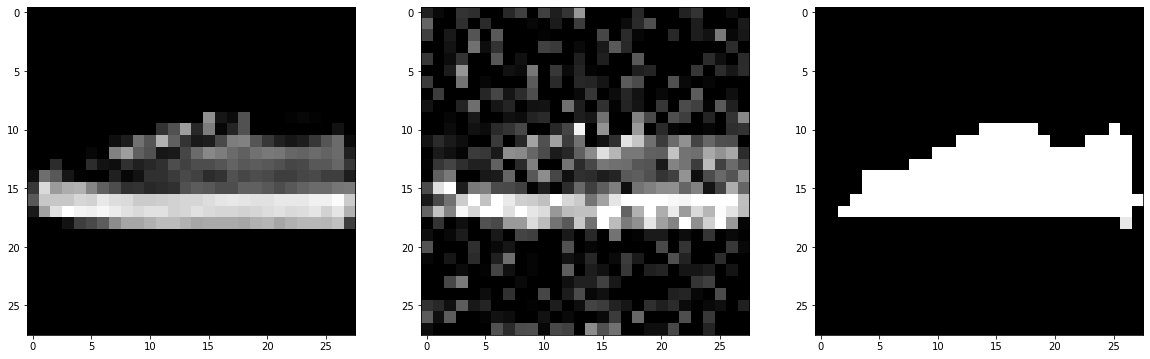

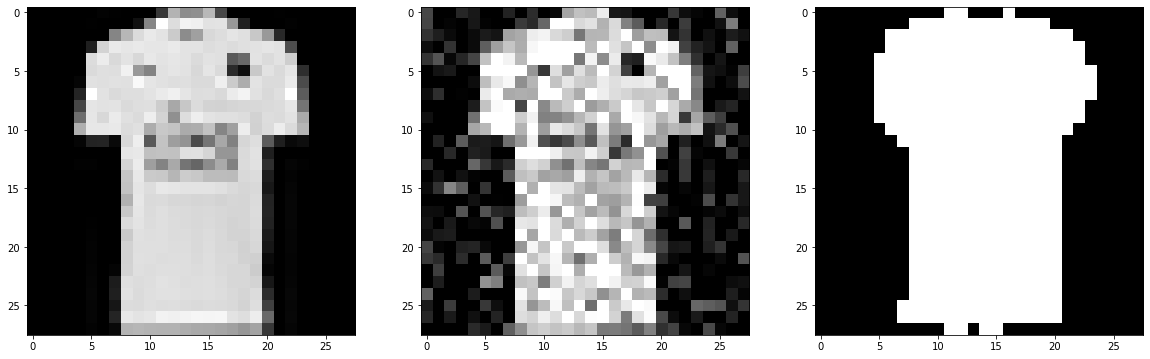

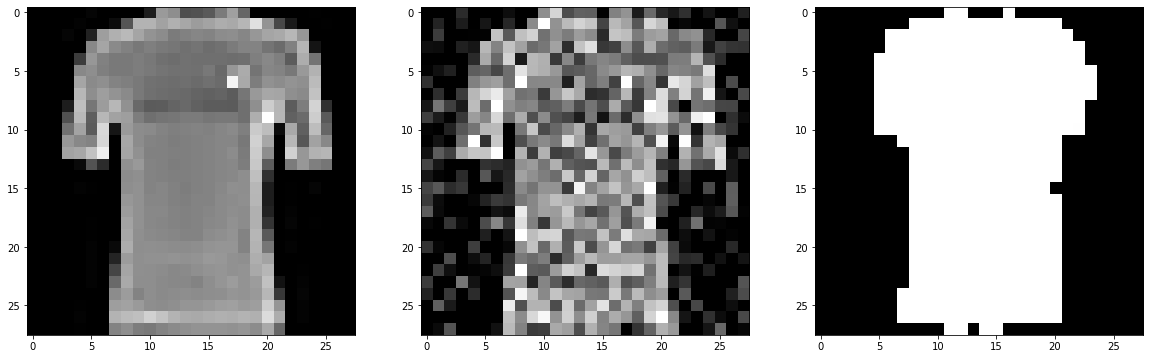

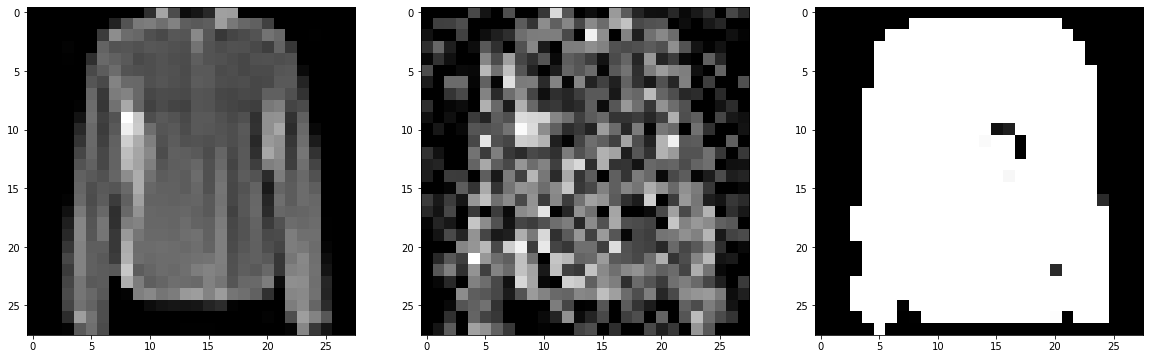

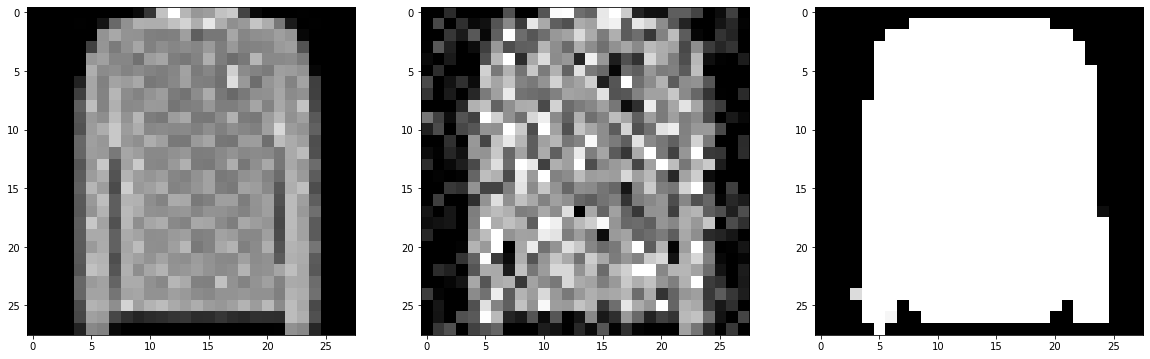

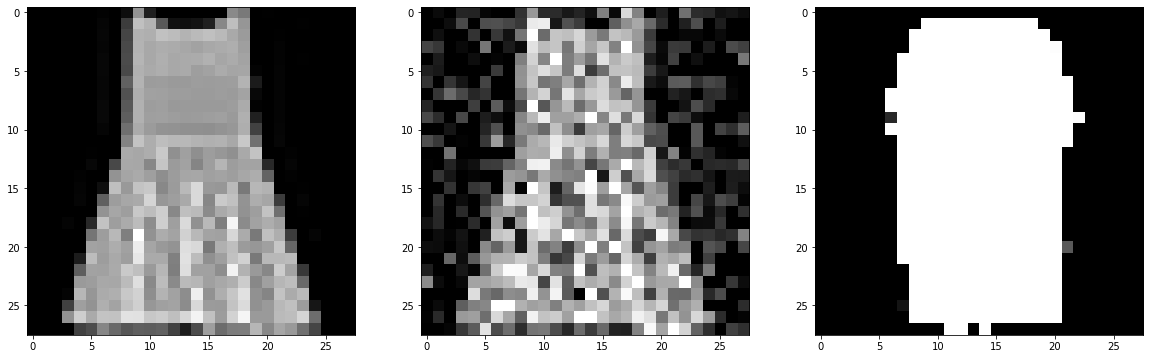

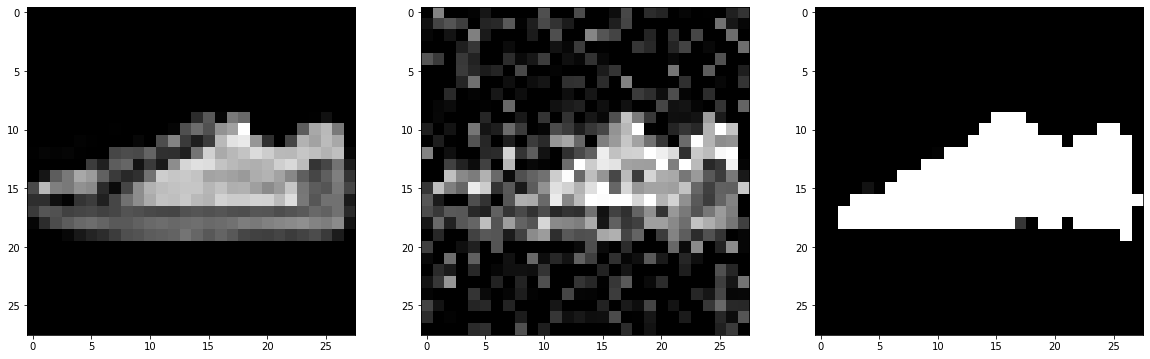

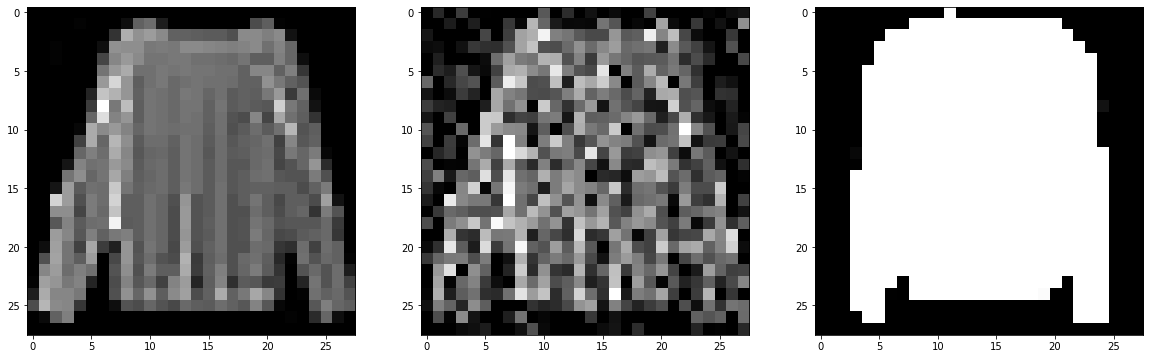

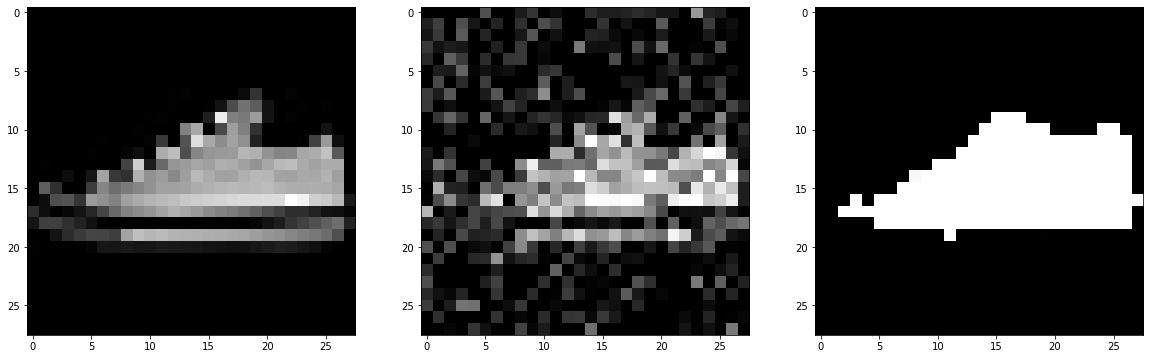

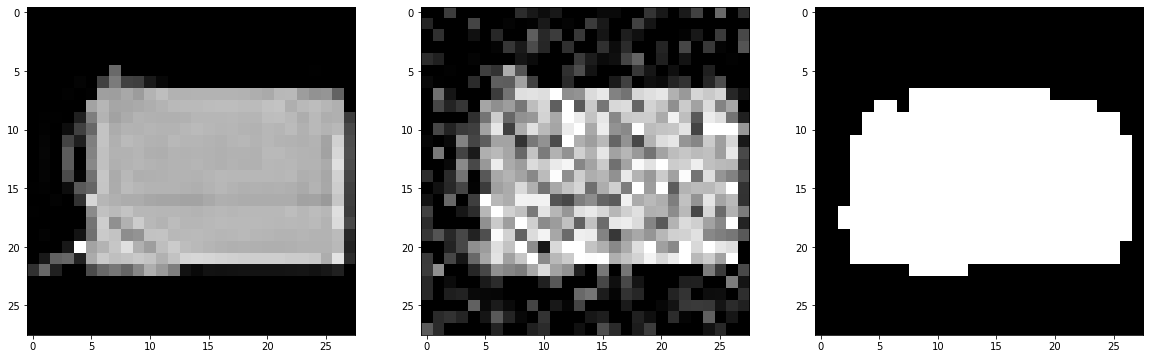

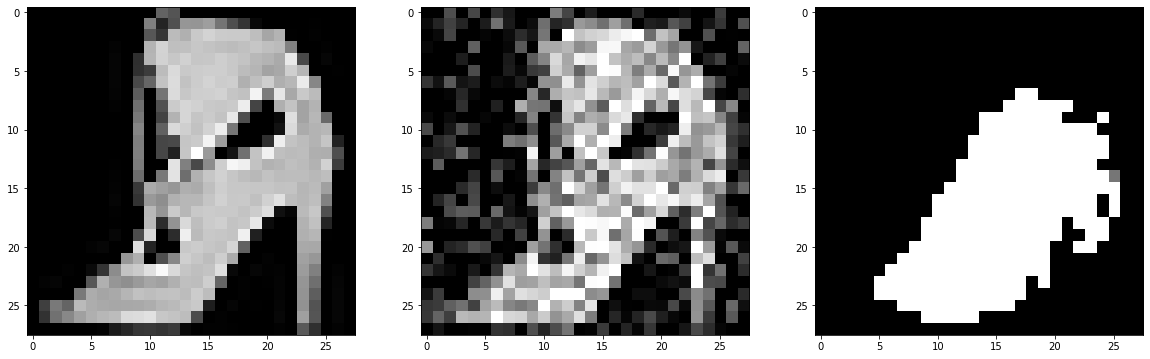

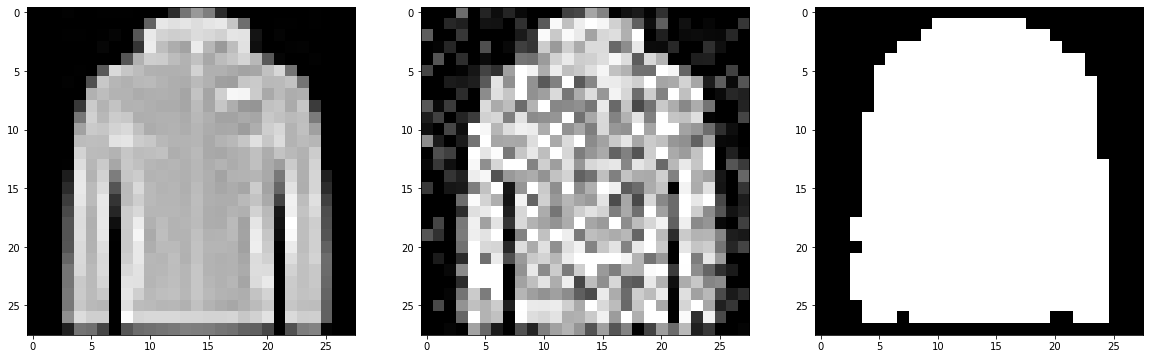

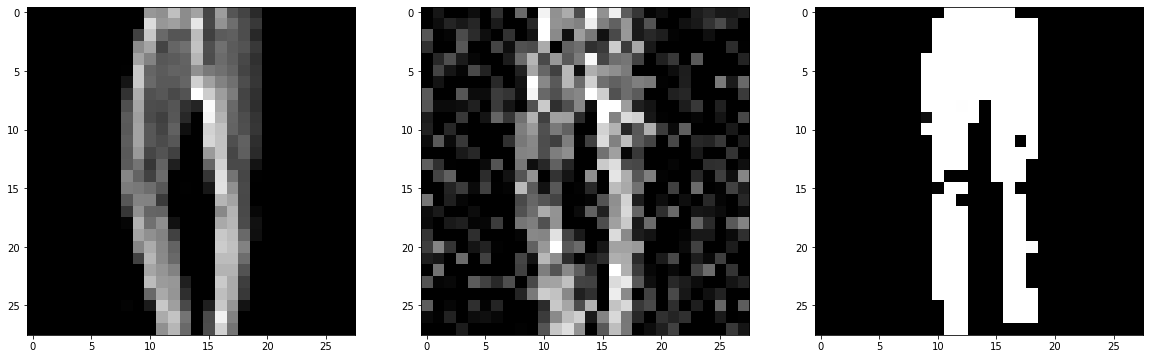

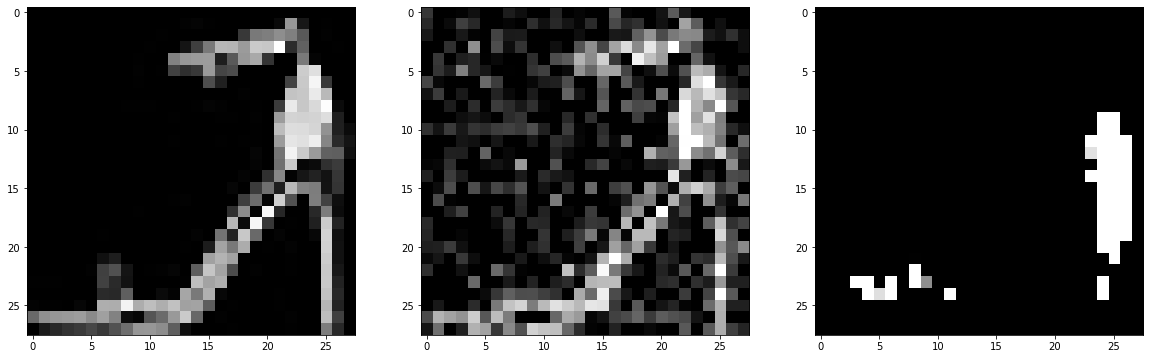

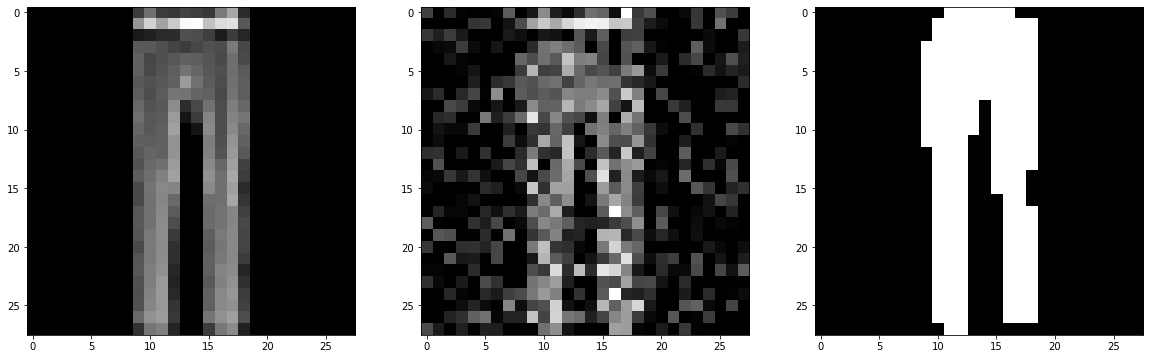

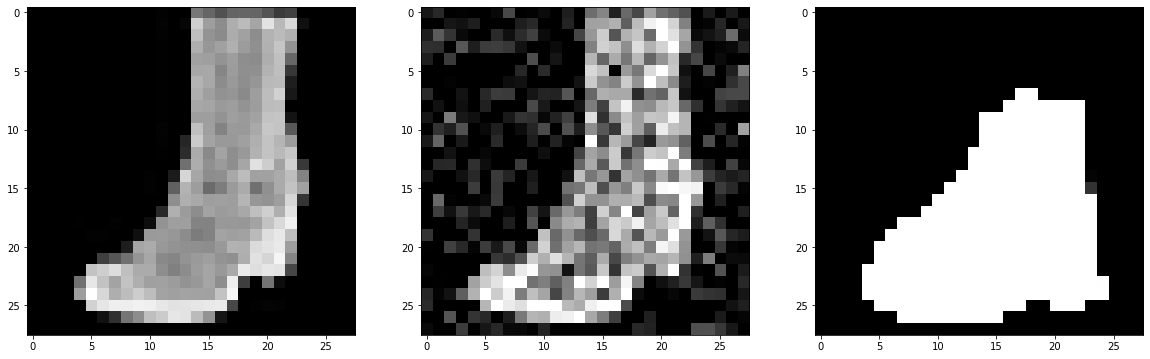

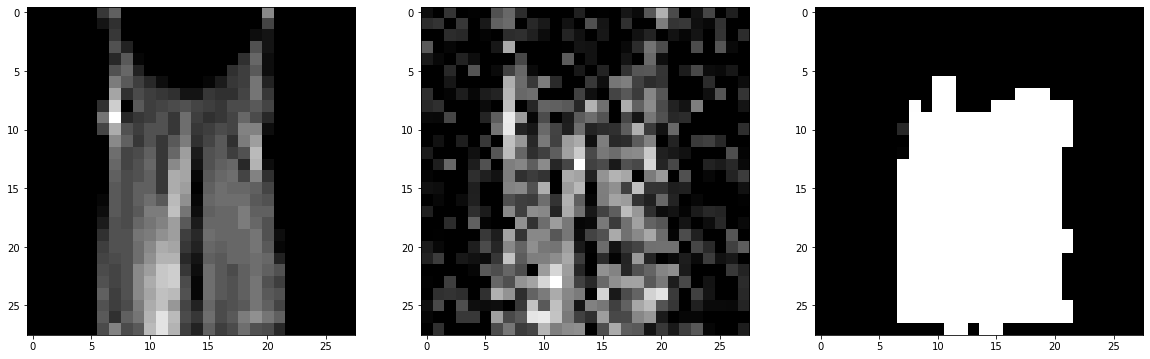

In [31]:
import random
import math

tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
te_x_noisy = get_noisy_images(te_x)
denoised = nn.predict(te_x_noisy, None)

# te_x          10000x784
# te_x_noisy    10000x784

te_x = tf.multiply(te_x, 255)
te_x = tf.math.round(te_x)
te_x = te_x.numpy()

te_x_noisy = tf.multiply(te_x_noisy, 255)
te_x_noisy = tf.math.round(te_x_noisy)
te_x_noisy = te_x_noisy.numpy()

te_x_denoised = tf.transpose(nn.predict(te_x_noisy, None))
te_x_denoised = tf.multiply(te_x_denoised, 255)
te_x_denoised = tf.math.round(te_x_denoised)
te_x_denoised = te_x_denoised.numpy()

def draw_graph(noisy:np.ndarray, \
               denoised:np.ndarray, \
               original:np.ndarray)->None:
  noisy = np.reshape(noisy, (28, 28,))
  denoised = np.reshape(denoised, (28, 28,))
  original = np.reshape(original, (28, 28,))
  fig, ax = plt.subplots(1, 3)
  ax[0].imshow(original, cmap='gray')
  ax[1].imshow(noisy, cmap='gray')
  ax[2].imshow(denoised, cmap='gray')
  plt.show()

visited = set()
for i in range(50):
  while True:
    ind = random.randrange(0, te_x_denoised.shape[0])
    if ind not in visited:
      break
  visited.add(ind)
  draw_graph(te_x_noisy[ind,:], te_x_denoised[ind,:], te_x[ind,:])
